# Early Reinforcement Learning

With the advances of modern computing power, the study of Reinforcement Learning is having a heyday. Machines are now able to learn complex tasks once thought to be solely in the domain of humans, from controlling the [heating and cooling in massive data centers](https://www.technologyreview.com/s/611902/google-just-gave-control-over-data-center-cooling-to-an-ai/) to beating [grandmasters at Starcraft](https://storage.googleapis.com/deepmind-media/research/alphastar/AlphaStar_unformatted.pdf). As magnificent as it may seem today, it had humble roots many decades ago. Seeing how far it's come, it's a wonder to see how far it will go!

Let's take a step back in time to see how these early algorithms developed. Many of these algorithms make sense given the context of when they were created. Challenge yourself and see if you can come up with the same strategies given the right problem. Ok! Time to cozy up for a story.

<img src="images/hero.jpg" width="488" height="172">

This is the hero of our story, the gumdrop emoji. It was enjoying a cool winter day building a snowman when suddenly, it slipped and fell on a frozen lake of death.


<img src="images/lake.jpg" width="900" height="680">

The lake can be thought of as a 4 x 4 grid where the gumdrop can move left (0), down (1), right (2) and up (3). Unfortunately, this frozen lake of death has holes of death where if the gumdrop enters that square, it will fall in and meet an untimely demise. To make matters worse, the lake is surrounded by icy boulders that if the gumdrop attempts to climb, will have it slip back into its original position. Thankfully, at the bottom right of the lake is a safe ramp that leads to a nice warm cup of hot cocoa.

## Set Up

We can try and save the gumdrop ourselves! This is a common game people begin their Reinforcement Learning journey with, and is included in the OpenAI's python package [Gym](https://gym.openai.com/) and is aptly named [FrozenLake-v0](https://gym.openai.com/envs/FrozenLake-v0/) ([code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)). No time to waste, let's get the environment up and running. Run the below to install the needed libraries if they are not installed already.

In [ ]:
# Replace with the Tensorflow version that you selected while creating the instance.
# !pip install tensorflow==2.x --user

**NOTE**: In the output of the above cell you may ignore any WARNINGS or ERRORS related to the dependency resolver.

If you get any related errors mentioned above please rerun the above cell.

In [ ]:
#!pip install gymnasium --user
#!pip install gymnasium[toy-text]

There are [four methods from Gym](http://gym.openai.com/docs/) that are going to be useful to us in order to save the gumdrop.
* `make` allows us to build the environment or game that we can pass actions to
* `reset` will reset an environment to it's starting configuration and return the state of the player
* `render` displays the environment for human eyes
* `step` takes an action and returns the player's next state.

Let's make, reset, and render the game. The output is an ANSI string with the following characters:
* `S` for starting point
* `F` for frozen
* `H` for hole
* `G` for goal
* A red square indicates the current position

**Note**: Restart the kernel if the above libraries needed to be installed


In [1]:
import gymnasium as gym
import numpy as np
import random

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array")
state = env.reset()

If we print the state we'll get `0`. This is telling us which square we're in. Each square is labeled from `0` to `15` from left to right, top to bottom, like this:

| | | | |
|-|-|-|-|
|0|1|2|3|
|4|5|6|7|
|8|9|10|11|
|12|13|14|15|


In [2]:
print(state)

(0, {'prob': 1})


We can make a simple print function to let us know whether it's game won, game over, or game on.

In [3]:
import matplotlib.pyplot as plt


def print_state(state, done):
    statement = "Still Alive!"
    if done:
        statement = "Cocoa Time!" if state == 15 else "Game Over!"
    print(state, "-", statement)
    image_render = env.render()
    plt.imshow(image_render)

We can control the gumdrop ourselves with the `step` method. Run the below cell over and over again trying to move from the starting position to the goal. Good luck!

1 - Still Alive!


error: XDG_RUNTIME_DIR not set in the environment.


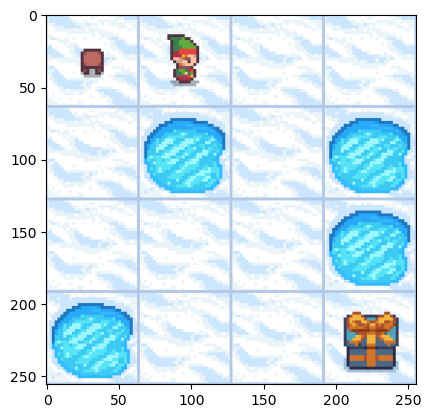

In [4]:
#0 left
#1 down
#2 right
#3 up

# Uncomment to reset the game
env.reset()
action = 2  # Change me, please!
state, _, done, _, _ = env.step(action)
env.render()
print_state(state, done)

Were you able to reach the hot chocolate? If so, great job! There are multiple paths through the maze. One solution is `[1, 1, 2, 2, 1, 2]`. Let's loop through our actions in order to get used to interacting with the environment programmatically.

4 - Still Alive!
8 - Still Alive!
9 - Still Alive!
10 - Still Alive!
14 - Still Alive!
15 - Cocoa Time!


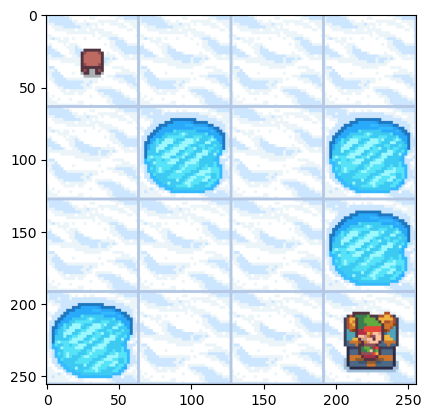

In [5]:
def play_game(actions):
    state = env.reset()
    step = 0
    done = False

    while not done and step < len(actions):
        action = actions[step]
        state, _, done, _, _ = env.step(action)
        env.render()
        step += 1
        print_state(state, done)


actions = [1, 1, 2, 2, 1, 2]  # Replace with your favorite path.
play_game(actions)

Nice, so we know how to get through the maze, but how do we teach that to the gumdrop? It's just some bytes in an android phone. It doesn't have our human insight.

We could give it our list of actions directly, but then it would be copying us and not really learning. This was a tricky one to the mathematicians and computer scientists originally trying to solve this problem. How do we teach a machine to do this without human insight?

## Value Iteration

Let's turn the clock back on our time machines to 1957 to meet Mr. [Richard Bellman](https://en.wikipedia.org/wiki/Richard_E._Bellman). Bellman started his academic career in mathematics, but due to World War II, left his postgraduate studies at John Hopkins to teach electronics as part of the war effort (as chronicled by J. J. O'Connor and E. F. Robertson [here](https://www-history.mcs.st-andrews.ac.uk/Biographies/Bellman.html)). When the war was over, and it came time for him to focus on his next area of research, he became fascinated with [Dynamic Programming](https://en.wikipedia.org/wiki/Dynamic_programming): the idea of breaking a problem down into sub-problems and using recursion to solve the larger problem.

Eventually, his research landed him on [Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process). These processes are a graphical way of representing how to make a decision based on a current state. States are connected to other states with positive and negative rewards that can be picked up along the way.

Sound familiar at all? Perhaps our Frozen Lake?

In the lake case, each cell is a state. The `H`s and the `G` are a special type of state called a "Terminal State", meaning they can be entered, but they have no leaving connections. What of rewards? Let's say the value of losing our life is the negative opposite of getting to the goal and staying alive. Thus, we can assign the reward of entering a death hole as -1, and the reward of escaping as +1.

Bellman's first breakthrough with this type of problem is now known as Value Iteration ([his original paper](http://www.iumj.indiana.edu/IUMJ/FULLTEXT/1957/6/56038)). He introduced a variable, gamma (γ), to represent discounted future rewards. He also introduced a function of policy (π) that takes a state (s), and outputs corresponding suggested action (a). The goal is to find the value of a state (V), given the rewards that occur when following an action in a particular state (R).

Gamma, the discount, is the key ingredient here. If my time steps were in days, and my gamma was .9, `$100` would be worth `$100` to me today, `$90` tomorrow, `$81` the day after, and so on. Putting this all together, we get the Bellman Equation

<img src="images/bellman_equation.jpg" width="500">

source: [Wikipedia](https://en.wikipedia.org/wiki/Bellman_equation)

In other words, the value of our current state, `current_values`, is equal to the discount times the value of the next state, `next_values`, given the policy the agent will follow. For now, we'll have our agent assume a greedy policy: it will move towards the state with the highest calculated value. If you're wondering what P is, don't worry, we'll get to that later.

Let's program it out and see it in action! We'll set up an array representing the lake with -1 as the holes, and 1 as the goal. Then, we'll set up an array of zeros to start our iteration.

In [6]:
LAKE = np.array([[0, 0, 0, 0],
                 [0, -1, 0, -1],
                 [0, 0, 0, -1],
                 [-1, 0, 0, 1]])
LAKE_WIDTH = len(LAKE[0])
LAKE_HEIGHT = len(LAKE)

DISCOUNT = .9  # Change me to be a value between 0 and 1.
current_values = np.zeros_like(LAKE)

The Gym environment class has a handy property for finding the number of states in an environment called `observation_space`. In our case, there a 16 integer states, so it will label it as "Discrete". Similarly, `action_space` will tell us how many actions are available to the agent.

Let's take advantage of these to make our code portable between different lakes sizes.

In [7]:
print("env.observation_space -", env.observation_space)
print("env.observation_space.n -", env.observation_space.n)
print("env.action_space -", env.action_space)
print("env.action_space.n -", env.action_space.n)

STATE_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n
STATE_RANGE = range(STATE_SPACE)
ACTION_RANGE = range(ACTION_SPACE)

env.observation_space - Discrete(16)
env.observation_space.n - 16
env.action_space - Discrete(4)
env.action_space.n - 4


We'll need some sort of function to figure out what the best neighboring cell is. The below function take's a cell of the lake, and looks at the current value mapping (to be called with `current_values`, and see's what the value of the adjacent state is corresponding to the given `action`.

In [8]:
def get_neighbor_value(state_x, state_y, values, action):
    """Returns the value of a state's neighbor.
    
    Args:
        state_x (int): The state's horizontal position, 0 is the lake's left.
        state_y (int): The state's vertical position, 0 is the lake's top.
        values (float array): The current iteration's state values.
        policy (int): Which action to check the value for.
        
    Returns:
        The corresponding action's value.
    """
    left = [state_y, state_x - 1]
    down = [state_y + 1, state_x]
    right = [state_y, state_x + 1]
    up = [state_y - 1, state_x]
    actions = [left, down, right, up]

    direction = actions[action]
    check_x = direction[1]
    check_y = direction[0]

    is_boulder = check_y < 0 or check_y >= LAKE_HEIGHT \
                 or check_x < 0 or check_x >= LAKE_WIDTH

    value = values[state_y, state_x]
    if not is_boulder:
        value = values[check_y, check_x]

    return value

In [9]:
def get_next_state(curent_state, action):
    state_y, state_x  = curent_state
    next_state = curent_state
    if action == 0: 
        next_state = [state_y, state_x - 1]
    if action == 1: 
        next_state = [state_y + 1, state_x]
    if action == 2: 
        next_state = [state_y, state_x + 1]
    if action == 3: 
        next_state = [state_y - 1, state_x]
    if next_state[0] < 0 or next_state[0] >= LAKE_HEIGHT or next_state[1] < 0 or next_state[1] >= LAKE_WIDTH:
        next_state = [state_y, state_x]
    return next_state

In [10]:
def get_next_state_value(next_state, values):
    next_value = values[next_state[0], next_state[1]]
    return next_value

But this doesn't find the best action, and the gumdrop is going to need that if it wants to greedily get off the lake. The `get_max_neighbor` function we've defined below takes a number corresponding to a cell as `state_number` and the same value mapping as `get_neighbor_value`.

In [11]:
def get_state_coordinates(state_number):
    state_x = state_number % LAKE_WIDTH
    state_y = state_number // LAKE_HEIGHT
    return state_x, state_y


def get_max_neighbor(state_number, values):
    """Finds the maximum valued neighbor for a given state.
    
    Args:
        state_number (int): the state to find the max neighbor for
        state_values (float array): the respective value of each state for
            each cell of the lake.
    
    Returns:
        max_value (float): the value of the maximum neighbor.
        policy (int): the action to take to move towards the maximum neighbor.
    """
    state_x, state_y = get_state_coordinates(state_number)

    # No policy or best value yet
    best_policy = -1
    max_value = -np.inf

    # If the cell has something other than 0, it's a terminal state.
    if LAKE[state_y, state_x]:
        return LAKE[state_y, state_x], best_policy

    for action in ACTION_RANGE:
        neighbor_value = get_neighbor_value(state_x, state_y, values, action)
        if neighbor_value > max_value:
            max_value = neighbor_value
            best_policy = action

    return max_value, best_policy

In [12]:
def get_max_value_of_next_state(current_state, values):
    best_action = -1
    max_value = -np.inf
    
    if LAKE[current_state[0], current_state[1]]:
        return LAKE[current_state[0], current_state[1]], best_action
        
    for action in ACTION_RANGE:
        next_action_state = get_next_state(current_state, action)
        next_action_value = get_next_state_value(next_action_state, values)
        if next_action_value > max_value:
            max_value = next_action_value
            best_action = action
    return max_value*DISCOUNT, best_action

Now, let's write our value iteration code. We'll write a function that comes out one step of the iteration by checking each state and finding its maximum neighbor. The values will be reshaped so that it's in the form of the lake, but the policy will stay as a list of ints. This way, when Gym returns a state, all we need to do is look at the corresponding index in the policy list to tell our agent where to go.

In [13]:
def iterate_value(current_values):
    """Finds the future state values for an array of current states.
    
    Args:
        current_values (int array): the value of current states.

    Returns:
        next_values (int array): The value of states based on future states.
        next_policies (int array): The recommended action to take in a state.
    """
    next_values = []
    next_policies = []

    for state in STATE_RANGE:
        value, policy = get_max_neighbor(state, current_values)
        next_values.append(value)
        next_policies.append(policy)

    next_values = np.array(next_values).reshape((LAKE_HEIGHT, LAKE_WIDTH))
    return next_values, next_policies


next_values, next_policies = iterate_value(current_values)

In [14]:
def iterate_value_new(current_values):
    next_values = []
    next_policies = []

    for state in STATE_RANGE:
        state_x, state_y = get_state_coordinates(state)
        max_value, next_action = get_max_value_of_next_state([state_y, state_x], current_values)
        next_values.append(max_value)
        next_policies.append(next_action)

    next_values = np.array(next_values).reshape((LAKE_HEIGHT, LAKE_WIDTH))
    return next_values, next_policies


In [15]:
current_values_new = np.zeros_like(LAKE)
next_values_new, next_policies_new = iterate_value_new(current_values_new)

This is what our values look like after one step. Right now, it just looks like the lake. That's because we started with an array of zeros for `current_values`, and the terminal states of the lake were loaded in.

In [16]:
next_values
next_values_new

array([[ 0.,  0.,  0.,  0.],
       [ 0., -1.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [-1.,  0.,  0.,  1.]])

And this is what our policy looks like reshaped into the form of the lake. The `-1`'s are terminal states. Right now, the agent will move left in any non-terminal state, because it sees all of those states as equal. Remember, if the gumdrop is along the leftmost side of the lake, and tries to move left, it will slip on a boulder and return to the same position.

In [17]:
np.array(next_policies).reshape((LAKE_HEIGHT, LAKE_WIDTH))
np.array(next_policies_new).reshape((LAKE_HEIGHT, LAKE_WIDTH))

array([[ 0,  0,  0,  0],
       [ 0, -1,  0, -1],
       [ 0,  0,  0, -1],
       [-1,  0,  0, -1]])

There's one last step to apply the Bellman Equation, the `discount`! We'll multiply our next states by the `discount` and set that to our `current_values`. One loop done!

In [18]:
current_values = DISCOUNT * next_values
current_values

array([[ 0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.9,  0. , -0.9],
       [ 0. ,  0. ,  0. , -0.9],
       [-0.9,  0. ,  0. ,  0.9]])

Run the below cell over and over again to see how our values change with each iteration. It should be complete after six iterations when the values no longer change. The policy will also change as the values are updated.

In [19]:
current_values = np.zeros_like(LAKE)
current_values_new = np.zeros_like(LAKE)
for i in range(10):
    next_values, next_policies = iterate_value(current_values)
    next_values_new, next_policies_new = iterate_value_new(current_values_new)
    print("---------------------------------------------------")
    print("Value at loop:", i)
    print(next_values)
    print("Policy at loop:", i)
    print(np.array(next_policies).reshape((4, 4)))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Value new at loop:", i)
    print(next_values_new)
    print("Policy new at loop:", i)
    print(np.array(next_policies_new).reshape((4, 4)))    
    current_values = DISCOUNT * next_values
    current_values_new = next_values_new

---------------------------------------------------
Value at loop: 0
[[ 0  0  0  0]
 [ 0 -1  0 -1]
 [ 0  0  0 -1]
 [-1  0  0  1]]
Policy at loop: 0
[[ 0  0  0  0]
 [ 0 -1  0 -1]
 [ 0  0  0 -1]
 [-1  0  0 -1]]
++++++++++++++++++++++++++++++++++++++++++++++++++++
Value new at loop: 0
[[ 0.  0.  0.  0.]
 [ 0. -1.  0. -1.]
 [ 0.  0.  0. -1.]
 [-1.  0.  0.  1.]]
Policy new at loop: 0
[[ 0  0  0  0]
 [ 0 -1  0 -1]
 [ 0  0  0 -1]
 [-1  0  0 -1]]
---------------------------------------------------
Value at loop: 1
[[ 0.   0.   0.   0. ]
 [ 0.  -1.   0.  -1. ]
 [ 0.   0.   0.  -1. ]
 [-1.   0.   0.9  1. ]]
Policy at loop: 1
[[ 0  0  0  0]
 [ 0 -1  1 -1]
 [ 0  0  0 -1]
 [-1  1  2 -1]]
++++++++++++++++++++++++++++++++++++++++++++++++++++
Value new at loop: 1
[[ 0.   0.   0.   0. ]
 [ 0.  -1.   0.  -1. ]
 [ 0.   0.   0.  -1. ]
 [-1.   0.   0.9  1. ]]
Policy new at loop: 1
[[ 0  0  0  0]
 [ 0 -1  1 -1]
 [ 0  0  0 -1]
 [-1  1  2 -1]]
---------------------------------------------------
Value at loop:

Have a completed policy? Let's see it in action! We'll update our `play_game` function to instead take our list of policies. That way, we can start in a random position and still get to the end.

0
action 1
4 - Still Alive!
action 1
8 - Still Alive!
action 2
9 - Still Alive!
action 1
13 - Still Alive!
action 2
14 - Still Alive!
action 2
15 - Cocoa Time!


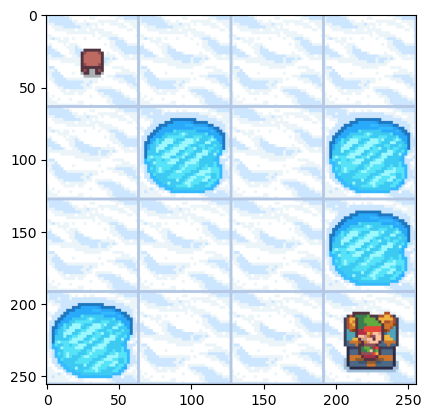

In [20]:
def play_game(policy):
    state = env.reset()[0]
    print(state)
    step = 0
    done = False

    while not done and step < 100:
        action = policy[state]  # This line is new.
        print("action", action)
        state, _, done, _, _ = env.step(action)
        env.render()
        step += 1
        print_state(state, done)


play_game(np.array(next_policies))

Phew! Good job, team! The gumdrop made it out alive. So what became of our gumdrop hero? Well, the next day, it was making another snowman and fell onto an even more slippery and deadly lake. Doh! Turns out this story is part of a trilogy. Feel free to move onto the next section after your own sip of cocoa, coffee, tea, or poison of choice.

## Policy Iteration

You may have noticed that the first lake was built with the parameter `is_slippery=False`. This time, we're going to switch it to `True`.

(0, {'prob': 1}) - Still Alive!


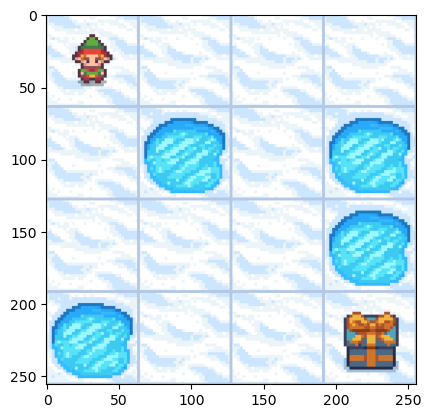

In [21]:
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode="rgb_array")
state = env.reset()
print_state(state, False)

Hmm, looks the same as before. Let's try applying our old policy and see what happens.

0
action 1
4 - Still Alive!
action 1
5 - Game Over!


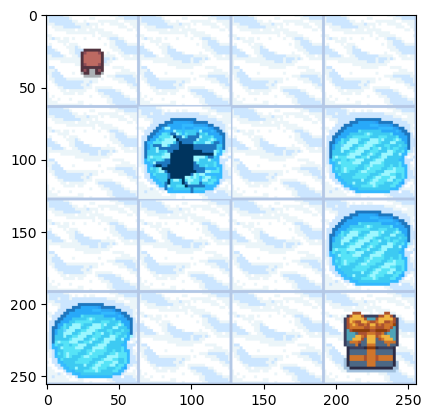

In [22]:
play_game(next_policies)

Was there a game over? There's a small chance that the gumdrop made it to the end, but it's much more likely that it accidentally slipped and fell into a hole. Oh no! We can try repeatedly testing the above code cell over and over again, but it might take a while. In fact, this is a similar roadblock Bellman and his colleagues faced.

How efficient is Value Iteration? On our modern machines, this algorithm ran fairly quickly, but back in 1960, that wasn't the case. Let's say our lake is a long straight line like this:

| | | | | | | |
|-|-|-|-|-|-|-|
|S|F|F|F|F|F|H|

This is the worst case scenario for value iteration. In each iteration, we look at every state (s) and each action per state (a), so one step of value iteration is O(s*a). In the case of our lake line, each iteration only updates one cell. In other words, the value iteration step needs to be run `s` times. In total, that's O(s<sup>2</sup>a).

Back in 1960, that was computationally heavy, and so [Ronald Howard](https://en.wikipedia.org/wiki/Ronald_A._Howard) developed an alteration of Value Iteration that mildly sacrificed mathematical accuracy for speed.

Here's the strategy: it was observed that the optimal policy often converged before value iteration was complete. To take advantage of this, we'll start with random policy. When we iterate over our values, we'll use this policy instead of trying to find the maximum neighbor. This has been coded out in `find_future_values` below.

In [23]:
def find_future_values(current_values, current_policies):
    """Finds the next set of future values based on the current policy."""
    next_values = []

    for state in STATE_RANGE:
        current_policy = current_policies[state]
        state_x, state_y = get_state_coordinates(state)

        # If the cell has something other than 0, it's a terminal state.
        value = LAKE[state_y, state_x]
        if not value:
            value = get_neighbor_value(
                state_x, state_y, current_values, current_policy)
        next_values.append(value)

    return np.array(next_values).reshape((LAKE_HEIGHT, LAKE_WIDTH))

After we've calculated our new values, then we'll update the policy (and not the values) based on the maximum neighbor. If there's no change in the policy, then we're done. The below is very similar to our `get_max_neighbor` function. Can you see the differences?

In [24]:
def find_best_policy(next_values):
    """Finds the best policy given a value mapping."""
    next_policies = []
    for state in STATE_RANGE:
        state_x, state_y = get_state_coordinates(state)

        # No policy or best value yet
        max_value = -np.inf
        best_policy = -1

        if not LAKE[state_y, state_x]:
            for policy in ACTION_RANGE:
                neighbor_value = get_neighbor_value(
                    state_x, state_y, next_values, policy)
                if neighbor_value > max_value:
                    max_value = neighbor_value
                    best_policy = policy

        next_policies.append(best_policy)
    return next_policies

To complete the Policy Iteration algorithm, we'll combine the two functions above. Conceptually, we'll be alternating between updating our value function and updating our policy function.

In [25]:
def iterate_policy(current_values, current_policies):
    """Finds the future state values for an array of current states.
    
    Args:
        current_values (int array): the value of current states.
        current_policies (int array): a list where each cell is the recommended
            action for the state matching its index.

    Returns:
        next_values (int array): The value of states based on future states.
        next_policies (int array): The recommended action to take in a state.
    """
    next_values = find_future_values(current_values, current_policies)
    next_policies = find_best_policy(next_values)
    return next_values, next_policies

Next, let's modify the `get_neighbor_value` function to now include the slippery ice. Remember the `P` in the Bellman Equation above? It stands for the probability of ending up in a new state given the current state and action taken. That is, we'll take a weighted sum of the values of all possible states based on our chances to be in those states.

How does the physics of the slippery ice work? For this lake, whenever the gumdrop tries to move in a particular direction, there are three possible positions that it could end up with. It could move where it was intending to go, but it could also end up to the left or right of the direction it was facing. For instance, if it wanted to move right, it could end up on the square above or below it! This is depicted below, with the yellow squares being potential positions after attempting to move right.

<img src="images/slipping.jpg" width="360" height="270">

Each of these has an equal probability chance of happening. So since there are three outcomes, they each have about a 33% chance to happen. What happens if we slip in the direction of a boulder? No problem, we'll just end up not moving anywhere. Let's make a function to find what our possible locations could be given a policy and state coordinates.

In [26]:
def get_locations(state_x, state_y, policy):
    left = [state_y, state_x - 1]
    down = [state_y + 1, state_x]
    right = [state_y, state_x + 1]
    up = [state_y - 1, state_x]
    directions = [left, down, right, up]
    num_actions = len(directions)

    gumdrop_right = (policy - 1) % num_actions
    gumdrop_left = (policy + 1) % num_actions
    locations = [gumdrop_left, policy, gumdrop_right]
    return [directions[location] for location in locations]

Then, we can add it to `get_neighbor_value` to find the weighted value of all the possible states the gumdrop can end up in.

In [27]:
def get_neighbor_value(state_x, state_y, values, policy):
    """Returns the value of a state's neighbor.
    
    Args:
        state_x (int): The state's horizontal position, 0 is the lake's left.
        state_y (int): The state's vertical position, 0 is the lake's top.
        values (float array): The current iteration's state values.
        policy (int): Which action to check the value for.
        
    Returns:
        The corresponding action's value.
    """
    locations = get_locations(state_x, state_y, policy)
    location_chance = 1.0 / len(locations)
    total_value = 0

    for location in locations:
        check_x = location[1]
        check_y = location[0]

        is_boulder = check_y < 0 or check_y >= LAKE_HEIGHT \
                     or check_x < 0 or check_x >= LAKE_WIDTH

        value = values[state_y, state_x]
        if not is_boulder:
            value = values[check_y, check_x]
        total_value += location_chance * value

    return total_value

For Policy Iteration, we'll start off with a random policy if only because the Gumdrop doesn't know any better yet. We'll reset our current values while we're at it.

In [28]:
current_values = np.zeros_like(LAKE)
policies = np.random.choice(ACTION_RANGE, size=STATE_SPACE)
np.array(policies).reshape((4, 4))

array([[0, 1, 3, 3],
       [0, 3, 1, 0],
       [2, 3, 2, 1],
       [3, 3, 2, 0]])

As before with Value Iteration, run the cell below multiple until the policy no longer changes. It should only take 2-3 clicks compared to Value Iteration's 6.

In [29]:
next_values, policies = iterate_policy(current_values, policies)
print("Value")
print(next_values)
print("Policy")
print(np.array(policies).reshape((4, 4)))
current_values = DISCOUNT * next_values

Value
[[ 0.  0.  0.  0.]
 [ 0. -1.  0. -1.]
 [ 0.  0.  0. -1.]
 [-1.  0.  0.  1.]]
Policy
[[ 0  3  0  3]
 [ 0 -1  0 -1]
 [ 3  1  0 -1]
 [-1  2  1 -1]]


Hmm, does this work? Let's see! Run the cell below to watch the gumdrop slip its way to victory.

0
action 0
0 - Still Alive!
action 0
0 - Still Alive!
action 0
4 - Still Alive!
action 0
0 - Still Alive!
action 0
0 - Still Alive!
action 0
0 - Still Alive!
action 0
4 - Still Alive!
action 0
0 - Still Alive!
action 0
0 - Still Alive!
action 0
0 - Still Alive!
action 0
4 - Still Alive!
action 0
8 - Still Alive!
action 3
8 - Still Alive!
action 3
9 - Still Alive!
action 1
13 - Still Alive!
action 2
13 - Still Alive!
action 2
14 - Still Alive!
action 1
14 - Still Alive!
action 1
15 - Cocoa Time!


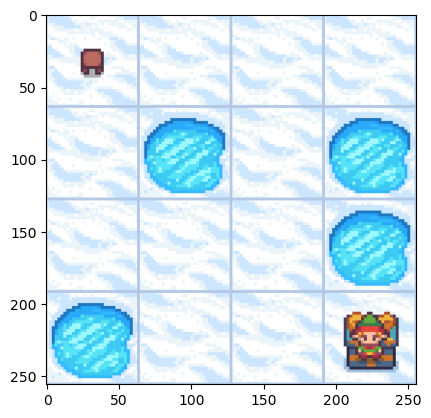

In [30]:
play_game(policies)

So what was the learned strategy here? The gumdrop learned to hug the left wall of boulders until it was down far enough to make a break for the exit. Instead of heading directly for it though, it took advantage of actions that did not have a hole of death in them. Patience is a virtue!

We promised this story was a trilogy, and yes, the next day, the gumdrop fell upon a frozen lake yet again.

## Q Learning
Value Iteration and Policy Iteration are great techniques, but what if we don't know how big the lake is? With real world problems, not knowing how many potential states are can be a definite possibility.

Enter [Chris Watkins](http://www.cs.rhul.ac.uk/~chrisw/). Inspired by how animals learn with delayed rewards, he came up with the idea of [Q Learning](http://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf) as an evolution of [Richard Sutton's](https://en.wikipedia.org/wiki/Richard_S._Sutton) [Temporal Difference Learning](https://en.wikipedia.org/wiki/Temporal_difference_learning). Watkins noticed that animals learn from positive and negative rewards, and that they often make mistakes in order to optimize a skill.

From this emerged the idea of a Q table. In the lake case, it would look something like this.

| |Left|Down|Right|Up|
|-|-|-|-|-|
|0| | | | |
|1| | | | |
|...| | | | |

Here's the strategy: our agent will explore the environment. As the agent observes new states, we'll add more rows to our table. Whenever it moves from one state to the next, we'll update the cell corresponding to the old state based on the Bellman Equation. The agent doesn't need to know what the probabilities are between transitions. It'll learn the value of these as it experiments.

For Q learning, this works by looking at the row that corresponds to the agent's current state. Then, we'll select the action with the highest value. There are multiple ways to initialize the Q-table, but for us, we'll start with all zeros. In that case, when selecting the best action, we'll randomly select between tied max values. If we don't, the agent will favor certain actions which will limit its exploration.

To be able to handle an unknown number of states, we'll initialize our q_table as one row to represent our initial state. Then, we'll make a dictionary to map new states to rows in the table.

In [31]:
new_row = np.zeros((1, env.action_space.n))
q_table = np.copy(new_row)
q_map = {0: 0}


def print_q(q_table, q_map):
    print("mapping")
    print(q_map)
    print("q_table")
    print(q_table)


print_q(q_table, q_map)

mapping
{0: 0}
q_table
[[0. 0. 0. 0.]]


Our new `get_action` function will help us read the `q_table` and find the best action.

First, we'll give the agent the ability to act randomly as opposed to choosing the best known action. This gives it the ability to explore and find new situations. This is done with a random chance to act randomly. So random!

When the Gumdrop chooses not to act randomly, it will instead act based on the best action recorded in the `q_table`. Numpy's [argwhere](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argwhere.html) is used to find the indexes with the maximum value in the q-table row corresponding to our current state. Since numpy is often used with higher dimensional data, each index is returned as a list of ints. Our indexes are really one dimensional since we're just looking within a single row, so we'll use [np.squeeze](https://docs.scipy.org/doc/numpy/reference/generated/numpy.squeeze.html) to remove the extra brackets. To randomly select from the indexes, we'll use [np.random.choice](https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.random.choice.html).

In [32]:
def get_action(q_map, q_table, state_row, random_rate):
    """Find max-valued actions and randomly select from them."""
    if random.random() < random_rate:
        return random.randint(0, ACTION_SPACE - 1)

    action_values = q_table[state_row]
    max_indexes = np.argwhere(action_values == action_values.max())
    max_indexes = np.squeeze(max_indexes, axis=-1)
    action = np.random.choice(max_indexes)
    return action

Here, we'll define how the `q_table` gets updated. We'll apply the Bellman Equation as before, but since there is so much luck involved between slipping and random actions, we'll update our `q_table` as a weighted average between the `old_value` we're updating and the `future_value` based on the best action in the next state. That way, there's a little bit of memory between old and new experiences.

In [33]:
def update_q(q_table, new_state_row, reward, old_value):
    """Returns an updated Q-value based on the Bellman Equation."""
    learning_rate = .1  # Change to be between 0 and 1.
    future_value = reward + DISCOUNT * np.max(q_table[new_state_row])
    return old_value + learning_rate * (future_value - old_value)

We'll update our `play_game` function to take our table and mapping, and at the end, we'll return any updates to them. Once we observe new states, we'll check our mapping and add then to the table if space isn't allocated for them already.

Finally, for every `state` - `action` - `new-state` transition, we'll update the cell in `q_table` that corresponds to the `state` and `action` with the Bellman Equation.

There's a little secret to solving this lake problem, and that's to have a small negative reward when moving between states. Otherwise, the gumdrop will become too afraid of slipping in a death hole to explore out of what is thought to be safe positions.

In [46]:
def play_game(q_table, q_map, random_rate, render=False):
    state = env.reset()[0]
    step = 0
    done = False

    while not done:
        state_row = q_map[state]
        action = get_action(q_map, q_table, state_row, random_rate)
        result = env.step(action)
        print(result)
        new_state, _, done, _, _ = result

        #Add new state to table and mapping if it isn't there already.
        if new_state not in q_map:
            q_map[new_state] = len(q_table)
            q_table = np.append(q_table, new_row, axis=0)
        new_state_row = q_map[new_state]

        reward = -.01  #Encourage exploration.
        if done:
            reward = 1 if new_state == 15 else -1
        current_q = q_table[state_row, action]
        q_table[state_row, action] = update_q(
            q_table, new_state_row, reward, current_q)

        step += 1
        if render:
            env.render()
            print_state(new_state, done)
        state = new_state

    return q_table, q_map

Ok, time to shine, gumdrop emoji! Let's do one simulation and see what happens.

In [47]:
# Run to refresh the q_table.
random_rate = 1
q_table = np.copy(new_row)
q_map = {0: 0}

(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(4, 0.0, False, False, {'prob': 0.3333333333333333})
4 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(4, 0.0, False, False, {'prob': 0.3333333333333333})
4 - Still Alive!
(0, 0.0, False, False, {'prob': 0.3333333333333333})
0 - Still Alive!
(4, 0.0, False, False, {'prob': 0.3333333333333333})
4 - Still Alive!
(8, 0.0, False, False, {'prob': 0.3333333333333333})
8 - Still Alive!
(9, 0.0, False, False, {'prob': 0.3333333333333333})
9 - Still Alive!
(8, 0.0, False, False, {'prob': 0.3333333333333333})
8 - Still Alive!
(4, 0.0, False, Fals

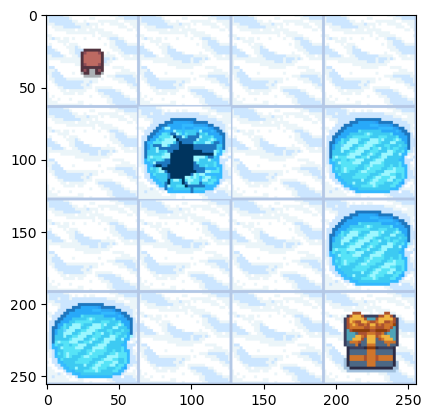

In [48]:
q_table, q_map = play_game(q_table, q_map, random_rate, render=True)
print_q(q_table, q_map)

Unless the gumdrop was incredibly lucky, chances were, it fell in some death water. Q-learning is markedly different from Value Iteration or Policy Iteration in that it attempts to simulate how an animal learns in unknown situations. Since the layout of the lake is unknown to the Gumdrop, it doesn't know which states are death holes, and which ones are safe. Because of this, it's going to make many mistakes before it can start making successes.

Feel free to run the above cell multiple times to see how the gumdrop steps through trial and error. When you're ready, run the below cell to have the gumdrop play 1000 times.

In [ ]:
for _ in range(1000):
    q_table, q_map = play_game(q_table, q_map, random_rate)
    random_rate = random_rate * .99
print_q(q_table, q_map)
random_rate

Cats have nine lives, our Gumdrop lived a thousand! Moment of truth. Can it get out of the lake now that it matters?

In [ ]:
q_table, q_map = play_game(q_table, q_map, 0, render=True)

Third time's the charm!

Each of these techniques has its pros and cons. For instance, while Value Iteration is the mathematically correct solution, it's not as time efficient at Policy Iteration or as flexible as Q-Learning.

| |Value Iteration|Policy Iteration|Q Tables|
|-|-|-|-|
|Avoids locally optimal routes|✓|x|x|
|On-policy (greedy)|✓|✓|x|
|Model Free|x|x|✓|
|Most time efficient|x|✓|x|

Congratulations on making it through to the end. Now if you ever fall on a Frozen Lake, you'll have many different ways to calculate your survival. The gumdrop thank you!

<img src="images/end.jpg" width="178" height="234">

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.